# JOBSHEET 10 - RECURRENT NEURAL NETWORK (RNN)

#### Nama: Magfiroh Indah Karisma
#### NIM: 2141720180

## PRAKTIKUM 1: RNN untuk Analisis Sentimen

### Setup
Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [1]:
import numpy as np  # Mengimpor modul numpy untuk operasi numerik efisien
import tensorflow_datasets as tfds  # Mengimpor tensorflow_datasets untuk mengakses dataset
import tensorflow as tf  # Mengimpor TensorFlow untuk pembuatan dan pelatihan model

# Mematikan progress bar saat mengunduh dataset menggunakan tensorflow_datasets
tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt  # Mengimpor modul matplotlib untuk membuat plot

def plot_graphs(history, metric):
  plt.plot(history.history[metric])  # Membuat plot untuk metrik pelatihan (misalnya: loss, accuracy) dari history
  plt.plot(history.history['val_'+metric], '')  # Membuat plot untuk metrik validasi dari history
  plt.xlabel("Epochs")  # Menandai label sumbu X sebagai "Epochs" (epoch)
  plt.ylabel(metric)  # Menandai label sumbu Y sesuai dengan nama metrik yang diberikan
  plt.legend([metric, 'val_'+metric])  # Menampilkan legenda pada plot, menunjukkan nama metrik pelatihan dan validasi

### Setup input pipeline
Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

Download dataset menggunakan TFDS. Lihat loading text tutorial jika ingin me load data secara manual

In [3]:
# Memuat dataset 'imdb_reviews' dengan informasi metadata (info) dan data sebagai pasangan (input, label)
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

# Memisahkan dataset menjadi data pelatihan (train_dataset) dan data uji (test_dataset)
train_dataset, test_dataset = dataset['train'], dataset['test']

# Menampilkan spesifikasi elemen dari dataset pelatihan
train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [5]:
# Menentukan ukuran buffer untuk proses pengacakan data dan ukuran batch yang akan digunakan
BUFFER_SIZE = 10000
BATCH_SIZE = 64

# Mengatur dataset latihan untuk diacak, dibagi ke dalam batch, dan dimuat ke dalam memori menggunakan tf.data.AUTOTUNE
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Mengatur dataset uji ke dalam batch yang sama dan memuat ke dalam memori menggunakan tf.data.AUTOTUNE
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Mengambil satu batch dari dataset latihan untuk dilihat
for example, label in train_dataset.take(1):
    # Mencetak sebagian contoh teks dari batch yang diambil
    print('texts: ', example.numpy()[:3])
    print()
    # Mencetak sebagian label yang sesuai dengan contoh teks
    print('labels: ', label.numpy()[:3])

texts:  [b'I collect Horror films from all over and I have seen the good and the very bad - Zombie Bloodbath is a low budget video. Sure, the acting is bad, the storyline is basically a mix of all zombie movies thrown together and the quality is low in some spots. The thing you seem to be missing is that it\'s still entertaining and really very fun. The effects range from, like someone on here has said, pasty-faced zombies that look like KISS rejects to really good ones with some amazing latex work. But the reason you buy a movie with a title like this is for the gore and this film is amazing in that area. The effects are very good for such a small film. Someone called it a Party movie and it is. 100% fun party movie. I have heard from various websites that this is actually a "rough cut" of the film that got general release but the actual "director\'s cut" is coming on DVD and it is very nice quality. I will buy it and judge for myself.<br /><br />Story is basically a Nuclear power pla

### Buat Teks Encoder

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [6]:
# Menentukan ukuran vocabulary yang akan digunakan untuk pengkodean teks
VOCAB_SIZE = 1000

# Membuat layer TextVectorization dengan jumlah token maksimum yang ditentukan
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)

# Menyesuaikan encoder terhadap dataset latihan untuk membangun vocabulary
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [7]:
# Mengambil vocabulary yang telah dibangun oleh encoder
vocab = np.array(encoder.get_vocabulary())

# Menampilkan 20 token pertama dalam vocabulary
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [8]:
# Menggunakan encoder untuk mengonversi contoh teks menjadi representasi angka
encoded_example = encoder(example)[:3].numpy()

# Menampilkan representasi angka dari 3 contoh teks pertama
encoded_example

array([[ 10,   1, 197, ...,   0,   0,   0],
       [ 51,  10,  86, ...,   0,   0,   0],
       [ 10, 116,   1, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:
- Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".
- Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [9]:
# Melakukan iterasi sebanyak 3 kali
for n in range(3):
    # Mencetak teks asli dari contoh teks
    print("Original: ", example[n].numpy())

    # Mencetak teks yang telah di-decode dari representasi angka kembali menjadi teks
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

Original:  b'I collect Horror films from all over and I have seen the good and the very bad - Zombie Bloodbath is a low budget video. Sure, the acting is bad, the storyline is basically a mix of all zombie movies thrown together and the quality is low in some spots. The thing you seem to be missing is that it\'s still entertaining and really very fun. The effects range from, like someone on here has said, pasty-faced zombies that look like KISS rejects to really good ones with some amazing latex work. But the reason you buy a movie with a title like this is for the gore and this film is amazing in that area. The effects are very good for such a small film. Someone called it a Party movie and it is. 100% fun party movie. I have heard from various websites that this is actually a "rough cut" of the film that got general release but the actual "director\'s cut" is coming on DVD and it is very nice quality. I will buy it and judge for myself.<br /><br />Story is basically a Nuclear power p

### Buat Model

Diagram model dapat dilihat pada gambar dimodul 10
1. Model ini dapat dibuat sebagai tf.keras.Sequential.
2. Lapisan pertama adalah encoder, yang mengubah teks menjadi urutan indeks token.
3. Setelah encoder adalah lapisan penyematan (embedding layer). Lapisan penyematan menyimpan satu vektor per kata. Saat dipanggil, ini mengubah rangkaian indeks kata menjadi rangkaian vektor. Vektor-vektor ini dapat dilatih. Setelah pelatihan (dengan data yang cukup), kata-kata dengan arti yang mirip sering kali memiliki vektor yang serupa. Pencarian indeks ini jauh lebih efisien daripada operasi setara dengan meneruskan vektor yang disandikan one-hot melalui lapisan tf.keras.layers.Dense.
4. Jaringan saraf berulang (RNN) memproses masukan urutan dengan melakukan iterasi melalui elemen. RNN meneruskan keluaran dari satu langkah waktu ke masukannya pada langkah waktu berikutnya.
Pembungkus tf.keras.layers.Bidirection juga dapat digunakan dengan lapisan RNN. Ini menyebarkan masukan maju dan mundur melalui lapisan RNN dan kemudian menggabungkan keluaran akhir.
- Keuntungan utama RNN dua arah adalah sinyal dari awal masukan tidak perlu diproses sepanjang waktu untuk memengaruhi keluaran.
- Kerugian utama dari RNN dua arah adalah Anda tidak dapat melakukan streaming prediksi secara efisien saat kata-kata ditambahkan di akhir.
5. Setelah RNN mengonversi urutan menjadi satu vektor, kedua lapisan tersebut.Dense melakukan beberapa pemrosesan akhir, dan mengonversi representasi vektor ini menjadi logit tunggal sebagai keluaran klasifikasi.

Kode nya adalah sebagai berikut :

In [10]:
# Membuat model sequential (urutan layer-layer)
model = tf.keras.Sequential([
    # Layer TextVectorization yang sudah di-adaptasi sebelumnya
    encoder,

    # Layer embedding dengan dimensi masukan sejumlah vocabulary yang dihasilkan oleh TextVectorization
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Menggunakan masking untuk menangani panjang urutan yang berbeda-beda
        mask_zero=True),

    # Layer LSTM bidireksional dengan 64 unit sel LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),

    # Layer Dense dengan 64 unit dan fungsi aktivasi relu
    tf.keras.layers.Dense(64, activation='relu'),

    # Layer Dense dengan 1 unit untuk output
    tf.keras.layers.Dense(1)
])

Harap dicatat bahwa model sekuensial Keras digunakan di sini karena semua lapisan dalam model hanya memiliki masukan tunggal dan menghasilkan keluaran tunggal. Jika Anda ingin menggunakan lapisan RNN stateful, Anda mungkin ingin membangun model Anda dengan API fungsional Keras atau subkelas model sehingga Anda dapat mengambil dan menggunakan kembali status lapisan RNN. Untuk detailnya bisa dilihat pada Keras RNN guide

Lapisan penyematan menggunakan masking (uses masking ) untuk menangani panjang urutan yang bervariasi. Semua lapisan setelah penyematan dukungan penyematan

In [11]:
# Memeriksa apakah setiap layer dalam model mendukung masking atau tidak
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [12]:
# Memprediksi sentimen dari sampel teks tanpa padding.
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Melakukan prediksi pada teks tertentu dengan model yang sudah dibuat
predictions = model.predict(np.array([sample_text]))

# Mencetak hasil prediksi
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[-0.00062611]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [13]:
# Memprediksi sentimen pada sebuah teks sampel dengan padding

# Menggunakan padding untuk menambah panjang teks
padding = "the " * 2000

# Melakukan prediksi pada teks sampel dengan dan tanpa padding menggunakan model yang sudah dilatih
predictions = model.predict(np.array([sample_text, padding]))

# Mencetak hasil prediksi
print(predictions[0])

1/1 [==============================] - 0s 60ms/step
[-0.00062611]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [14]:
# Mengompilasi model untuk pelatihan

# Menggunakan Binary Crossentropy sebagai fungsi loss karena ini merupakan masalah klasifikasi biner
# from_logits=True karena output model belum melewati fungsi aktivasi sigmoid
# Optimizer yang digunakan adalah Adam dengan learning rate 1e-4
# Metrics yang dipantau adalah akurasi
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

### Train Model

In [15]:
# Melatih model menggunakan data pelatihan dan data validasi

# model.fit() digunakan untuk melatih model dengan data pelatihan (train_dataset) selama 10 epochs.
# validation_data digunakan untuk menentukan dataset validasi (test_dataset) yang akan digunakan selama pelatihan.
# validation_steps menentukan jumlah langkah yang akan dievaluasi dari dataset validasi selama setiap epoch.
history = model.fit(
    train_dataset,  # Data pelatihan
    epochs=10,  # Jumlah epochs pelatihan
    validation_data=test_dataset,  # Data validasi
    validation_steps=30  # Jumlah langkah evaluasi pada dataset validasi setiap epoch
)

Epoch 1/10
391/391 [==============================] - 59s 124ms/step - loss: 0.6476 - accuracy: 0.5684 - val_loss: 0.5230 - val_accuracy: 0.7620
Epoch 2/10
391/391 [==============================] - 26s 65ms/step - loss: 0.4580 - accuracy: 0.7781 - val_loss: 0.3990 - val_accuracy: 0.8229
Epoch 3/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3717 - accuracy: 0.8366 - val_loss: 0.3744 - val_accuracy: 0.8365
Epoch 4/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3418 - accuracy: 0.8506 - val_loss: 0.3411 - val_accuracy: 0.8536
Epoch 5/10
391/391 [==============================] - 23s 59ms/step - loss: 0.3256 - accuracy: 0.8598 - val_loss: 0.3371 - val_accuracy: 0.8562
Epoch 6/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3137 - accuracy: 0.8664 - val_loss: 0.3282 - val_accuracy: 0.8609
Epoch 7/10
391/391 [==============================] - 25s 62ms/step - loss: 0.3098 - accuracy: 0.8694 - val_loss: 0.3229 - val_accuracy

In [16]:
# Menggunakan model.evaluate() untuk mengevaluasi model terhadap data test_dataset.
# Model dievaluasi untuk mendapatkan nilai loss dan akurasi pada dataset uji.

test_loss, test_acc = model.evaluate(test_dataset)  # Evaluasi model pada data test_dataset

# Mencetak nilai loss dan akurasi pada data uji (test_dataset).
print('Test Loss:', test_loss)  # Cetak nilai loss pada data uji
print('Test Accuracy:', test_acc)  # Cetak nilai akurasi pada data uji

391/391 [==============================] - 12s 30ms/step - loss: 0.3207 - accuracy: 0.8643
Test Loss: 0.3207304775714874
Test Accuracy: 0.8643199801445007


(0.0, 0.6649029806256295)

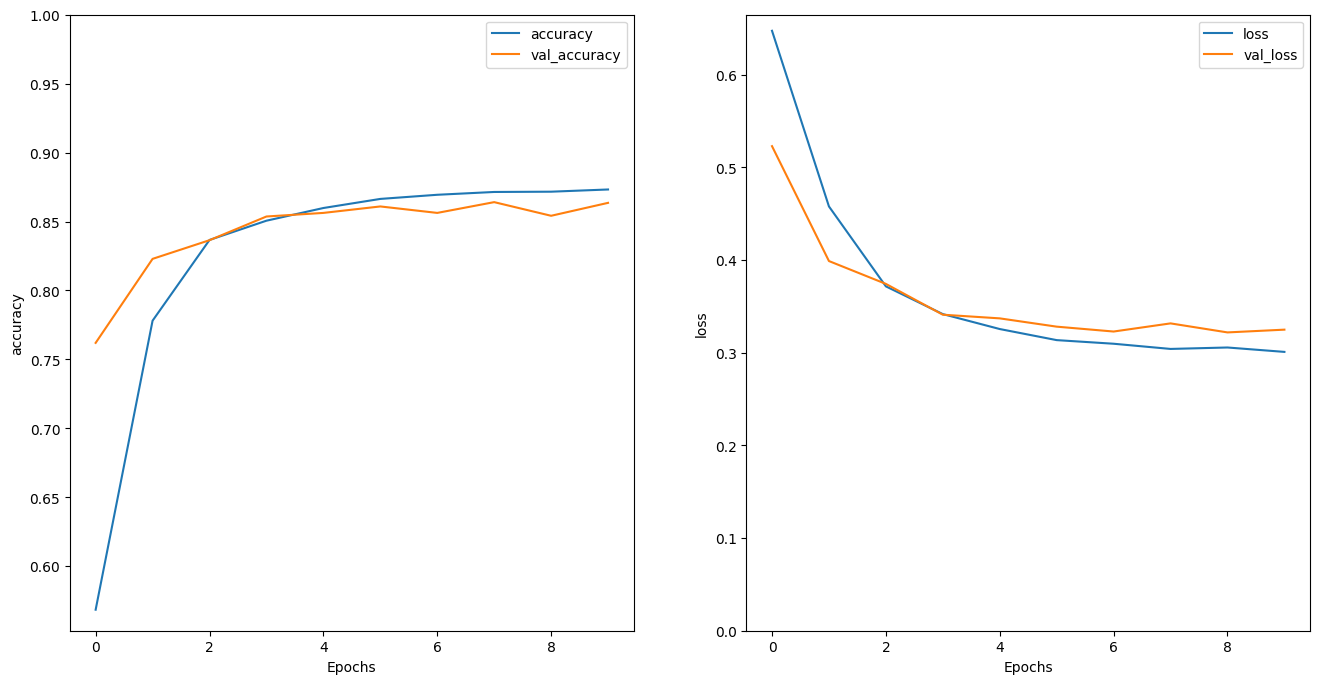

In [17]:
# Mengimpor library untuk plotting
import matplotlib.pyplot as plt

# Membuat gambar plot dengan ukuran 16x8
plt.figure(figsize=(16, 8))

# Menampilkan grafik akurasi
plt.subplot(1, 2, 1)  # Gambar plot di subplot 1, posisi (1 baris, 2 kolom, indeks 1)
plot_graphs(history, 'accuracy')  # Memanggil fungsi plot_graphs untuk plot akurasi
plt.ylim(None, 1)  # Mengatur batas sumbu y untuk akurasi (agar nilainya berada antara 0 dan 1)

# Menampilkan grafik loss
plt.subplot(1, 2, 2)  # Gambar plot di subplot 2, posisi (1 baris, 2 kolom, indeks 2)
plot_graphs(history, 'loss')  # Memanggil fungsi plot_graphs untuk plot loss
plt.ylim(0, None)  # Mengatur batas sumbu y untuk loss (agar nilainya dimulai dari 0)

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [18]:
# Sebuah contoh teks ulasan film
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Memprediksi sentimen ulasan film menggunakan model
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


### Stack two or more LSTM layers

Lapisan berulang Keras memiliki dua mode yang tersedia yang dikontrol oleh argumen konstruktor return_sequences :
- Jika False, ia hanya mengembalikan keluaran terakhir untuk setiap urutan masukan (bentuk tensor 2D (batch_size, output_features)). Ini adalah default yang digunakan pada model sebelumnya.
- Jika True, Sequence lengkap output berturut-turut untuk setiap langkah waktu dikembalikan (bentuk tensor 3D (ukuran_batch, langkah waktu, fitur_output)).

Berikut (pada modul) adalah alur informasi dengan return_sequences=True:
(gambar alur)

Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [21]:
model = tf.keras.Sequential([
  encoder, # Layer vektorisasi teks
  tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True), # Layer embedding dengan 64 dimensi dan masking nol
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), # Layer LSTM bidireksional dengan 64 unit, mengembalikan urutan
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), # Layer LSTM bidireksional dengan 32 unit
  tf.keras.layers.Dense(64, activation='relu'), # Layer Dense dengan 64 unit dan fungsi aktivasi ReLU
  tf.keras.layers.Dropout(0.5), # Layer Dropout untuk mencegah overfitting (tingkat dropout 50%)
  tf.keras.layers.Dense(1) # Layer output dengan 1 unit (klasifikasi biner)
])

In [22]:
model.compile(
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # Penggunaan fungsi Binary Cross Entropy sebagai fungsi loss untuk klasifikasi biner
  optimizer=tf.keras.optimizers.Adam(1e-4), # Penggunaan optimizer Adam dengan laju belajar 0.0001
  metrics=['accuracy'] # Penggunaan metrik akurasi untuk evaluasi model
)

In [23]:
history = model.fit(
  train_dataset, # Data latih yang akan digunakan
  epochs=10, # Jumlah epoch (siklus pelatihan) yang diinginkan
  validation_data=test_dataset, # Data validasi untuk evaluasi model selama pelatihan
  validation_steps=30 # Jumlah langkah yang akan dievaluasi selama setiap epoch pada data validasi
)

Epoch 1/10
391/391 [==============================] - 75s 146ms/step - loss: 0.6325 - accuracy: 0.5788 - val_loss: 0.4398 - val_accuracy: 0.7891
Epoch 2/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3836 - accuracy: 0.8305 - val_loss: 0.3583 - val_accuracy: 0.8479
Epoch 3/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3398 - accuracy: 0.8536 - val_loss: 0.3573 - val_accuracy: 0.8599
Epoch 4/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3234 - accuracy: 0.8626 - val_loss: 0.3313 - val_accuracy: 0.8453
Epoch 5/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3131 - accuracy: 0.8679 - val_loss: 0.3294 - val_accuracy: 0.8578
Epoch 6/10
391/391 [==============================] - 43s 109ms/step - loss: 0.3077 - accuracy: 0.8690 - val_loss: 0.3251 - val_accuracy: 0.8536
Epoch 7/10
391/391 [==============================] - 43s 109ms/step - loss: 0.3013 - accuracy: 0.8709 - val_loss: 0.3203 - val_ac

In [24]:
test_loss, test_acc = model.evaluate(test_dataset) # Evaluasi model pada data uji untuk menghitung loss dan akurasi
print('Test Loss:', test_loss) # Cetak nilai loss pada data uji
print('Test Accuracy:', test_acc) # Cetak nilai akurasi pada data uji

391/391 [==============================] - 19s 48ms/step - loss: 0.3172 - accuracy: 0.8565
Test Loss: 0.3171759843826294
Test Accuracy: 0.8565199971199036


In [25]:
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')  # Menyiapkan contoh teks untuk dilakukan prediksi
predictions = model.predict(np.array([sample_text]))  # Melakukan prediksi sentimen dari teks menggunakan model
print(predictions)  # Mencetak hasil prediksi sentimen dari teks tersebut

1/1 [==============================] - 6s 6s/step
[[-1.7873259]]


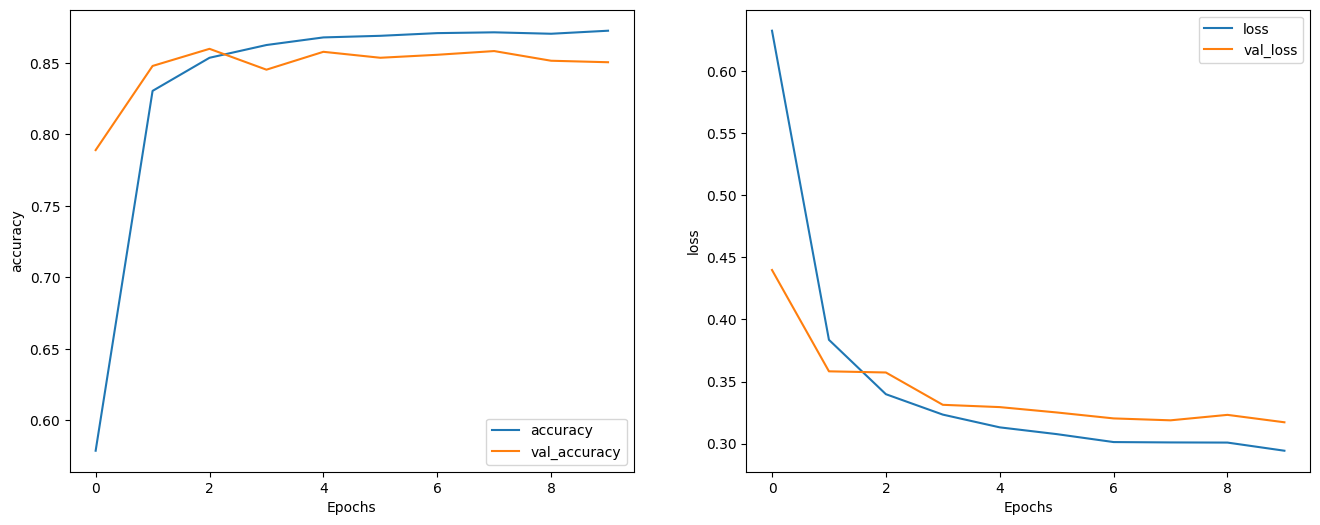

In [26]:
plt.figure(figsize=(16, 6))  # Membuat gambar baru dengan ukuran 16x6
plt.subplot(1, 2, 1)  # Membagi gambar menjadi 1 baris 2 kolom, menggunakan subplot pertama
plot_graphs(history, 'accuracy')  # Menampilkan grafik akurasi menggunakan fungsi plot_graphs
plt.subplot(1, 2, 2)  # Menggunakan subplot kedua
plot_graphs(history, 'loss')  # Menampilkan grafik loss menggunakan fungsi plot_graphs

## Praktikum 2: Generator Teks dengan RNN
Praktikum ini mendemonstrasikan cara melakukan genearsi text menggunakan RNN. Dataset yang digunkan adalah dataset Shakespeare's writing from Andrej Karpathy's. Jika diberikan urutan karakter dari data ini ("Shakespear"), latih model untuk memprediksi karakter berikutnya dalam urutan ("e"). Urutan teks yang lebih panjang dapat dihasilkan dengan memanggil model berulang kali.

Note: Enable GPU acceleration to execute this notebook faster. In Colab: Runtime > Change runtime type > Hardware accelerator > GPU.

Tutorial ini menggunakan tf.keras dan eager execution. Berikut adalah contoh output ketika model dalam tutorial ini dilatih selama 30 epoch, dan dimulai dengan prompt "Q":

QUEENE:
I had thought thou hadst a Roman; for the oracle,
Thus by All bids the man against the word,
Which are so weak of care, by old care done;
Your children were in your holy love,
And the precipitation through the bleeding throne.

BISHOP OF ELY:
Marry, and will, my lord, to weep in such a one were prettiest;
Yet now I was adopted heir
Of the world's lamentable day,
To watch the next way with his father with his face?

ESCALUS:
The cause why then we are all resolved more sons.

VOLUMNIA:
O, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, it is no sin it should be dead,
And love and pale as any will to that word.

QUEEN ELIZABETH:
But how long have I heard the soul for this world,
And show his hands of life be proved to stand.

PETRUCHIO:
I say he look'd on, if I must be content
To stay him from the fatal of our country's bliss.
His lordship pluck'd from this sentence then for prey,
And then let us twain, being the moon,
were she such a case as fills m

Meskipun beberapa kalimat memiliki tata bahasa, sebagian besar tidak masuk akal. Model belum mempelajari arti kata-kata, namun anggap saja:
- Modelnya berbasis karakter. Saat pelatihan dimulai, model tidak mengetahui cara mengeja kata dalam bahasa Inggris, atau bahkan kata-kata tersebut merupakan satuan teks.
- Struktur keluarannya menyerupai sandiwara—blok teks umumnya dimulai dengan nama pembicara, dengan huruf kapital semua mirip dengan kumpulan data.
- Seperti yang ditunjukkan di bawah, model dilatih pada kumpulan teks kecil (masing-masing 100 karakter), dan masih mampu menghasilkan rangkaian teks yang lebih panjang dengan struktur yang koheren.

### Setup

Import TensorFlow

In [27]:
import tensorflow as tf
import numpy as np
import os
import time

Download Dataset Shakespeare

Sesuaikan dengan lokasi data yang Anda punya.

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


Load Data

In [32]:
# Buka file pada path yang ditentukan dalam mode biner ('rb') dan decode isi file sebagai UTF-8 untuk mengonversi dari bentuk biner menjadi string
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

# Menghitung panjang teks, yang merepresentasikan jumlah karakter dalam file
print(f'Panjang teks: {len(text)} karakter')

Panjang teks: 1115394 karakter


In [33]:
# Melihat 250 karakter pertama dalam teks
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [34]:
# Karakter unik dalam file
vocab = sorted(set(text))
print(f'{len(vocab)} karakter unik')

65 karakter unik


### Olah Teks
Vectorize Teks

Sebelum training, Anda perlu mengonversi string menjadi representasi numerik. tf.keras.layers.StringLookup dapat mengubah setiap karakter menjadi ID numerik. Caranya adalah teks akan dipecah menjadi token terlebih dahulu.

In [35]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

sekarang buat tf.keras.layers.StringLookup layer:

In [36]:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

perintah diatas mengconvert token menjadi id

In [37]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

Karena tujuan tutorial ini adalah untuk menghasilkan teks, penting juga untuk membalikkan representasi ini. Untuk ini Anda dapat menggunakan kode tf.keras.layers.StringLookup(..., invert=True).

Catatan: pada kode ini, daripada meneruskan kosakata asli yang dihasilkan dengan diurutkan(set(teks)) gunakan metode get_vocabulary() dari tf.keras.layers.StringLookup sehingga token [UNK] disetel dengan cara yang sama.

In [38]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

Lapisan ini mengconvert kembali karakter dari vektor ID, dan mengembalikannya sebagai karakter tf.RaggedTensor:

In [40]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

Anda dapat menggunakan tf.strings.reduce_join untuk menggabungkan kembali karakter menjadi string.

In [41]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [42]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

Prediksi

Diberikan sebuah karakter, atau serangkaian karakter, karakter apa yang paling mungkin berikutnya? Ini adalah tugas yang harus Anda latih agar model dapat melakukannya. Masukan ke model akan berupa urutan karakter, dan Anda melatih model untuk memprediksi keluaran berupa karakter berikut pada setiap langkah waktu. Karena RNN mempertahankan keadaan internal yang bergantung pada elemen yang terlihat sebelumnya, mengingat semua karakter dihitung hingga saat ini, karakter apa selanjutnya?


Membuat Trianing Set dan Target

Selanjutnya bagilah teks menjadi contoh sequence. Setiap masukan sequence akan berisi karakter seq_length dari teks. Untuk setiap masukan sequence, target prediksi berisi teks dengan panjang yang sama, hanya digeser satu karakter ke kanan. Jadi, bagi teks menjadi beberapa bagian seq_length+1. Misalnya, seq_length adalah 4 dan teks kita adalah "Hello". Urutan masukannya adalah "Hell", dan urutan targetnya adalah "ello". Untuk melakukan ini, pertama-tama gunakan fungsi tf.data.Dataset.from_tensor_slices untuk mengonversi vektor teks menjadi aliran indeks karakter.

In [43]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [44]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [45]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [46]:
seq_length = 100

Metode batch memungkinkan Anda dengan mudah mengonversi karakter individual ini menjadi urutan ukuran yang diinginkan.

In [47]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


akan lebih mudah untuk melihat apa yang dilakukan jika Anda menggabungkan token kembali menjadi string:

In [48]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


Untuk pelatihan, Anda memerlukan kumpulan data pasangan (input, label). Dimana input dan label merupakan urutan. Pada setiap langkah waktu, inputnya adalah karakter saat ini dan labelnya adalah karakter berikutnya. Berikut adalah fungsi yang mengambil urutan sebagai masukan, menduplikasi, dan menggesernya untuk menyelaraskan masukan dan label untuk setiap langkah waktu:

In [49]:
def split_input_target(sequence):
    input_text = sequence[:-1]  # Mengambil teks input hingga karakter terakhir
    target_text = sequence[1:]  # Mengambil teks target dari karakter kedua hingga terakhir
    return input_text, target_text  # Mengembalikan teks input dan target

In [50]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [51]:
dataset = sequences.map(split_input_target)

In [52]:
for input_example, target_example in dataset.take(1):
  print("Input :", text_from_ids(input_example).numpy())
  print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


Membuat Batch Training

Anda menggunakan tf.data untuk membagi teks menjadi sequence yang dapat diatur. Namun sebelum memasukkan data ini ke dalam model, Anda perlu mengacak data dan mengemasnya ke dalam batch.

In [53]:
# Ukuran batch
BATCH_SIZE = 64

# Ukuran buffer untuk mengacak dataset
# (TF data dirancang untuk bekerja dengan urutan yang mungkin tak terbatas,
# sehingga tidak mencoba untuk mengacak urutan seluruh sequence di memori.
# Sebagai gantinya, ia mempertahankan buffer untuk mengacak elemen).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)  # Mengacak dataset
    .batch(BATCH_SIZE, drop_remainder=True)  # Mengelompokkan menjadi batch dengan ukuran yang ditentukan
    .prefetch(tf.data.experimental.AUTOTUNE)  # Mengoptimalkan prefetching untuk performance
)

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

### Buat Model

Bagian ini mendefinisikan model sebagai subkelas keras.Model (untuk lebih detilnya, lihat Making new Layers and Models via subclassing).

Model yang kita bangun memiliki 3 lapisan neural network :
- tf.keras.layers.Embedding: Lapisan masukan. Tabel pencarian yang dapat dilatih yang akan memetakan setiap karakter-ID ke vektor dengan dimensi embedding_dim;
- tf.keras.layers.GRU: lapisan RNN dengan ukuran unit=rnn_units (Anda juga dapat menggunakan lapisan LSTM di sini.)
- tf.keras.layers.Dense: Lapisan keluaran, dengan keluaran vocab_size. Ini menghasilkan satu logit untuk setiap karakter dalam kosakata. Ini adalah log kemungkinan setiap karakter menurut model.

In [54]:
# Panjang vokabulari dalam lapisan StringLookup
vocab_size = len(ids_from_chars.get_vocabulary())

# Dimensi embedding
embedding_dim = 256

# Jumlah unit RNN
rnn_units = 1024

In [55]:
class MyModel(tf.keras.Model):
  # Inisialisasi model dengan lapisan-lapisan yang akan digunakan
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    # Lapisan embedding untuk merepresentasikan karakter sebagai vektor numerik
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    # Lapisan GRU (Gated Recurrent Unit) untuk mengelola urutan karakter
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    # Lapisan Dense untuk prediksi distribusi probabilitas karakter selanjutnya
    self.dense = tf.keras.layers.Dense(vocab_size)

  # Fungsi pemanggilan model untuk memproses masukan melalui lapisan-lapisan
  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    # Proses masukan melalui lapisan embedding
    x = self.embedding(x, training=training)
    # Jika tidak ada keadaan yang diberikan, dapatkan keadaan awal dari GRU
    if states is None:
      states = self.gru.get_initial_state(x)
    # Proses masukan melalui lapisan GRU, menghasilkan keluaran dan keadaan baru
    x, states = self.gru(x, initial_state=states, training=training)
    # Proses hasil dari GRU melalui lapisan Dense untuk prediksi karakter
    x = self.dense(x, training=training)

    # Jika diperlukan, kembalikan keadaan dan keluaran GRU
    if return_state:
      return x, states
    else:
      return x

In [56]:
model = MyModel(
    vocab_size=vocab_size,  # Ukuran kosakata dari lapisan embedding
    embedding_dim=embedding_dim,  # Dimensi dari vektor embedding
    rnn_units=rnn_units  # Jumlah unit dalam lapisan GRU
)

Untuk setiap karakter, model mencari penyematan, menjalankan GRU satu langkah waktu dengan penyematan sebagai masukan, dan menerapkan dense layer untuk menghasilkan log yang memprediksi kemungkinan log karakter berikutnya:


Note: Untuk pelatihan Anda bisa menggunakan model keras.Sequential di sini. Untuk menghasilkan teks nanti, Anda harus mengelola status internal RNN. Akan lebih mudah untuk memasukkan opsi input dan output status di awal, daripada mengatur ulang arsitektur model nanti. untuk detailnya bisa dilihat Keras RNN guide.

### Uji Model
Coba jalankan model dan cek apakah sidah sesuai dengan output

pertama, cek bentuk dari output

In [57]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


Dalam contoh di atas, panjang urutan masukan adalah 100 tetapi model dapat dijalankan pada masukan dengan panjang berapa pun:

In [58]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Untuk mendapatkan prediksi aktual dari model, Anda perlu mengambil sampel dari distribusi keluaran, untuk mendapatkan indeks karakter aktual. Distribusi ini ditentukan oleh logit pada kosakata karakter.

Catatan: Penting untuk mengambil sampel dari distribusi ini karena mengambil argmax dari distribusi tersebut dapat dengan mudah membuat model terjebak dalam infinote loop. Cobalah untuk contoh pertama di batch:

In [59]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

Hal ini memberi kita, pada setiap langkah waktu, prediksi indeks karakter berikutnya:

In [60]:
sampled_indices

array([24, 10, 57,  0, 36,  8, 46, 20, 37, 21,  3, 35,  4, 60, 32, 35,  9,
       36, 52,  2,  6, 33,  1, 46, 58, 32, 45,  0, 44,  1, 37, 16, 51, 56,
       15, 37,  4, 21,  5,  2, 17, 11, 36, 11, 61, 51, 27, 48, 49, 57, 52,
       48, 10, 28, 42, 64,  5, 33, 13, 48, 35, 23, 41, 51, 24,  9, 50,  2,
       30, 46, 45, 54, 40, 19,  7, 39, 65, 64, 42, 15, 51, 29, 26, 32, 40,
       48, 65, 36, 64, 12, 54, 64, 59,  1, 17, 27, 13, 14, 19, 31])

Dekode kode berikut untuk melihat teks yang diprediksi oleh model tidak terlatih ini:

In [61]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b"ad bodies: I will apprehend him.\nStop thy unhallow'd toil, vile Montague!\nCan vengeance be pursued f"

Next Char Predictions:
 b"K3r[UNK]W-gGXH!V$uSV.Wm 'T\ngsSf[UNK]e\nXClqBX$H& D:W:vlNijrmi3Ocy&T?iVJblK.k QgfoaF,ZzycBlPMSaizWy;oyt\nDN?AFR"


### Train Model
Pada titik ini permasalahan dapat dianggap sebagai permasalahan klasifikasi standar. Permasalahan dapat disimpulkan dengan : Berdasarkan status RNN sebelumnya, dan masukan langkah kali ini, prediksi kelas karakter berikutnya.

Tambahan optimizer dan fungsi loss

loss function tf.keras.losses.sparse_categorical_crossentropy standar berfungsi dalam kasus ini karena diterapkan di seluruh dimensi terakhir prediksi. Karena model Anda mengembalikan logits, Anda perlu mengatur flag from_logits.

In [63]:
# Menggunakan fungsi SparseCategoricalCrossentropy untuk menghitung loss
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [64]:
# Menghitung rata-rata loss pada sebuah batch dari model
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)

# Menampilkan bentuk (shape) dari prediksi model
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")

# Menampilkan rata-rata loss pada batch tersebut
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1906056, shape=(), dtype=float32)


Model yang baru diinisialisasi tidak boleh terlalu yakin dengan dirinya sendiri, semua log keluaran harus memiliki besaran yang sama. Untuk mengonfirmasi hal ini, Anda dapat memeriksa bahwa eksponensial dari loss rata-rata harus kira-kira sama dengan ukuran kosakata. Loss yang jauh lebih tinggi berarti model tersebut yakin akan jawaban yang salah, dan memiliki inisialisasi yang buruk:

In [65]:
tf.exp(example_batch_mean_loss).numpy()

66.06279

Konfigurasikan prosedur pelatihan menggunakan metode tf.keras.Model.compile. Gunakan tf.keras.optimizers.Adam dengan argumen default dan fungsi loss.

In [70]:
model.compile(optimizer='adam', loss=loss)

Konfigurasi Checkpoints

Gunakan tf.keras.callbacks.ModelCheckpoint untuk memastikan bahwa checkpoint disimpan selama pelatihan:

In [66]:
# Direktori tempat penyimpanan checkpoint
checkpoint_dir = './training_checkpoints'

# Nama file untuk checkpoint
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# Membuat callback untuk menyimpan bobot model saja
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

Lakukan Proses Training

Agar waktu pelatihan tidak terlalu lama, gunakan 10 epoch untuk melatih model. Di Colab, setel runtime ke GPU untuk pelatihan yang lebih cepat.

In [67]:
EPOCHS = 20

In [71]:
# Melatih model dengan menggunakan dataset dan callback untuk menyimpan bobot
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 13s 55ms/step - loss: 2.7002
Epoch 2/20
172/172 [==============================] - 11s 53ms/step - loss: 1.9746
Epoch 3/20
172/172 [==============================] - 11s 54ms/step - loss: 1.6998
Epoch 4/20
172/172 [==============================] - 11s 54ms/step - loss: 1.5402
Epoch 5/20
172/172 [==============================] - 11s 55ms/step - loss: 1.4443
Epoch 6/20
172/172 [==============================] - 11s 55ms/step - loss: 1.3775
Epoch 7/20
172/172 [==============================] - 12s 55ms/step - loss: 1.3259
Epoch 8/20
172/172 [==============================] - 12s 56ms/step - loss: 1.2814
Epoch 9/20
172/172 [==============================] - 11s 57ms/step - loss: 1.2404
Epoch 10/20
172/172 [==============================] - 11s 57ms/step - loss: 1.2015
Epoch 11/20
172/172 [==============================] - 11s 57ms/step - loss: 1.1602
Epoch 12/20
172/172 [==============================] - 12s 61ms/step - loss: 1.1192
E

### Generate Teks

Cara termudah untuk menghasilkan teks dengan model ini adalah dengan menjalankannya dalam loop, dan menyimpan status internal model saat Anda menjalankannya.

Setiap kali Anda memanggil model, Anda memasukkan beberapa teks dan state internal. Model mengembalikan prediksi untuk karakter berikutnya dan state barunya. Masukkan kembali prediksi dan state ke model untuk terus menghasilkan teks.

Berikut ini membuat prediksi satu langkah:

In [72]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Membuat masker untuk mencegah "[UNK]" dari dihasilkan.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Menetapkan -inf pada setiap indeks yang tidak valid.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Sesuaikan bentuk dengan kosakata
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Mengonversi string menjadi token ID.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Menjalankan model.
    # Bentuk predicted_logits adalah [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Hanya menggunakan prediksi terakhir.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Menerapkan masker prediksi: mencegah "[UNK]" dari dihasilkan.
    predicted_logits = predicted_logits + self.prediction_mask

    # Mengambil sampel token ID dari logit keluaran.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Mengonversi dari token ID menjadi karakter.
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Mengembalikan karakter dan keadaan model.
    return predicted_chars, states

In [73]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

Jalankan secara berulang untuk menghasilkan beberapa teks. Melihat teks yang dihasilkan, Anda akan melihat model mengetahui kapan harus menggunakan huruf besar, membuat paragraf, dan meniru kosakata menulis seperti Shakespeare. Karena sedikitnya jumlah epoch pelatihan, model belum belajar membentuk kalimat runtut.

In [74]:
start = time.time()  # Memulai waktu eksekusi
states = None  # Menginisialisasi keadaan model menjadi None
next_char = tf.constant(['ROMEO:'])  # Mendefinisikan karakter awal sebagai 'ROMEO:'
result = [next_char]  # Menyimpan karakter awal dalam hasil

for n in range(1000):  # Melakukan iterasi untuk menghasilkan 1000 karakter selanjutnya
  next_char, states = one_step_model.generate_one_step(next_char, states=states)  # Menghasilkan karakter selanjutnya
  result.append(next_char)  # Menambahkan karakter hasil ke dalam daftar

result = tf.strings.join(result)  # Menggabungkan karakter-karakter hasil
end = time.time()  # Mengakhiri waktu eksekusi
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)  # Mencetak hasil teks yang dihasilkan
print('\nRun time:', end - start)  # Mencetak waktu eksekusi dari awal hingga akhir

ROMEO:
This doth conceit and payers from them.

GREme OF AUMERLE:
If sorrow born to say.
I pray you home by that? the trespass of the deed?

SICINIUS:
I think not mendly, O, afflict
me hastening of this conquire after lowd;
But let me see me so much done.

KING RICHARD II:
They keep many purpose.

MARCIUS:
They are come to the gain.

KING RICHARD II:
Mine ever who let me say, I do define the peditacion
From ever followers doom that pursuiss,
Look on me demess, I have well metine
speak not, received into a cockard such death:
That cannot leisure for revenge
Wife for our hour lord, within these armities
That's become a mean.

CAMILLO:
I vault
a there example. But, for my life,
Pray God possess with nerves, if ever fear
They'rt prevented that doth court again.

JULIET:
I doubt not but let me see my son?

KING RICHARD III:
No, my good friends will not have leave the leader,
Let him be crown'd, I'll bring them that was out,
And leave you near at me? But, pervaile,
When thou dost married the

Hal termudah yang dapat Anda lakukan untuk meningkatkan hasil adalah dengan melatihnya lebih lama (coba EPOCHS = 30). Anda juga dapat bereksperimen dengan string awal yang berbeda, mencoba menambahkan lapisan RNN lain untuk meningkatkan akurasi model, atau menyesuaikan parameter suhu untuk menghasilkan prediksi yang kurang lebih acak.

Jika Anda ingin model menghasilkan teks lebih cepat, hal termudah yang dapat Anda lakukan adalah membuat teks secara batch. Pada contoh di bawah, model menghasilkan 5 keluaran dalam waktu yang hampir sama dengan waktu yang dibutuhkan untuk menghasilkan 1 keluaran di atas.

In [75]:
start = time.time()  # Memulai waktu eksekusi
states = None  # Menginisialisasi keadaan model menjadi None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])  # Mendefinisikan beberapa karakter awal 'ROMEO:'
result = [next_char]  # Menyimpan karakter awal dalam hasil

for n in range(1000):  # Melakukan iterasi untuk menghasilkan 1000 karakter selanjutnya
  next_char, states = one_step_model.generate_one_step(next_char, states=states)  # Menghasilkan karakter selanjutnya
  result.append(next_char)  # Menambahkan karakter hasil ke dalam daftar

result = tf.strings.join(result)  # Menggabungkan karakter-karakter hasil
end = time.time()  # Mengakhiri waktu eksekusi
print(result, '\n\n' + '_'*80)  # Mencetak hasil teks yang dihasilkan
print('\nRun time:', end - start)  # Mencetak waktu eksekusi dari awal hingga akhir

tf.Tensor(
[b"ROMEO:\nNow, by this land, and let the place of you;\nLook in the vianon followers; I do leanness all\nWith flattere them that doth charge him of himself!\nIt shall be that you are?\n\nThird Servingman:\nBoth aud untimely valiant. O am in state,\nIf she shall be frank'd down and word may do whose height\nOf what we ised, forget' to me\nIn carber than the light against sometime.\n\nJonn! Signior Romeo, affection of men\nMay be well as if you please to-night.\nGive mischaring when he firsts about it.\n\nKING RICHARD II:\nWho is the greatest prevent thereof is, hate you\nquench their foemus ascuse they shall be;\ndawners will let give me that: Lord Hastings, let this dream,\nAnd live in patience that doth fare your honours.\nO, there, my good lord; a gross your ears herewell\nThe spluch for what content them.\n\nClown:\nMarry be the doot is well? if my care done?\n\nHORTENSIO:\nIf I please you to your father's slave,\nAnd bid a vire profording Claudio?\nIt sail a mad-knatles

### Ekspor Model Generator
Model satu langkah ini dapat dengan mudah disimpan dan digunakan kembali, memungkinkan Anda menggunakannya di mana pun tf.saved_model diterima.

In [76]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [77]:
# Inisialisasi variabel awal
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

# Loop untuk generate teks selanjutnya
for n in range(100):
    # Generate teks selanjutnya berdasarkan model yang telah dimuat
    next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
    result.append(next_char)

# Menggabungkan hasil generate menjadi sebuah teks
print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
Go to, we pratel he ere onch Warwick; then know me not!
I shall forget your tongue.

LEONTES:
Thou 


## Tugas
Prosedur pelatihan pada praktikum 2 merupakan prosedur sederhana, yang tidak memberi Anda banyak kendali. Model ini menggunakan "teacher-forcing" yang mencegah prediksi buruk diumpankan kembali ke model, sehingga model tidak pernah belajar untuk pulih dari kesalahan. Jadi, setelah Anda melihat cara menjalankan model secara manual, selanjutnya Anda akan mengimplementasikan custom loop pelatihan. Hal ini memberikan titik awal jika, misalnya, Anda ingin menerapkan pembelajaran kurikulum untuk membantu menstabilkan keluaran open-loop model. Bagian terpenting dari loop pelatihan khusus adalah fungsi langkah pelatihan.

Gunakan  untuk men track nilai gradient. Anda dapat mempelajari lebih lanjut tentang pendekatan ini dengan membaca .

Prosedurnya adalah :
1. Jalankan Model dan hitung loss dengan.
2. Hitung update dan terapkan pada model dengan optimizer

In [78]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
    inputs, labels = inputs
    with tf.GradientTape() as tape:
      predictions = self(inputs, training=True)
      loss = self.loss(labels, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return {'loss': loss}

Kode diatas menerapkan train_step method sesuai dengan  Keras' train_step conventions. Ini opsional, tetapi memungkinkan Anda mengubah perilaku langkah pelatihan dan tetap menggunakan keras Model.compile and Model.fit methods.

In [79]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [80]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [81]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 18s 61ms/step - loss: 2.7160


Atau jika ingin lebih mengetahui dalamnya, kita bisa membuat custom training loop sendiri:

In [82]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.1919
Epoch 1 Batch 50 Loss 2.0701
Epoch 1 Batch 100 Loss 1.9611
Epoch 1 Batch 150 Loss 1.8775

Epoch 1 Loss: 1.9909
Time taken for 1 epoch 14.47 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.8253
Epoch 2 Batch 50 Loss 1.7485
Epoch 2 Batch 100 Loss 1.6775
Epoch 2 Batch 150 Loss 1.6442

Epoch 2 Loss: 1.7111
Time taken for 1 epoch 12.09 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.6110
Epoch 3 Batch 50 Loss 1.5851
Epoch 3 Batch 100 Loss 1.5670
Epoch 3 Batch 150 Loss 1.5200

Epoch 3 Loss: 1.5510
Time taken for 1 epoch 10.76 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.4727
Epoch 4 Batch 50 Loss 1.4610
Epoch 4 Batch 100 Loss 1.4748
Epoch 4 Batch 150 Loss 1.3962

Epoch 4 Loss: 1.4530
Time taken for 1 epoch 11.91 sec
_____________________________________________________________________

Jalankan kode diatas dan sebutkan perbedaanya dengan praktikum 2?

Perbedaannya dengan praktikum sebelumnya adalah:

1. Penggunaan train_step Kustom: Dalam contoh ini, ada penggunaan metode train_step kustom yang memberikan kontrol lebih besar terhadap proses pelatihan dengan TensorFlow GradientTape. Ini memungkinkan Anda menyesuaikan perilaku pelatihan di dalam loop.

2. Iterasi Langsung pada Dataset: Loop pelatihan langsung melakukan iterasi pada dataset dan memanggil train_step untuk setiap batch. Hal ini memberikan kontrol penuh atas setiap langkah pelatihan.

3. Pemantauan dan Penyimpanan: Selama pelatihan, terdapat pemantauan terhadap loss untuk setiap batch dan setiap epoch. Selain itu, terdapat opsi untuk menyimpan model (checkpoint) setiap beberapa epoch.

4. Kontrol terhadap Optimizer dan Metrics: Dalam kode ini, Anda dapat menyesuaikan optimizer dan metrik sesuai kebutuhan, dan juga melakukan pemantauan manual terhadap loss.

5. Informasi Lebih Rinci: Anda mendapatkan informasi yang lebih rinci tentang setiap langkah pelatihan, seperti loss setiap batch, waktu yang dibutuhkan untuk setiap epoch, dan hasil akhir loss setiap epoch.

Implementasi kustom ini memberikan lebih banyak fleksibilitas dan kontrol penuh atas proses pelatihan model, memungkinkan penyesuaian yang lebih rinci dan pemantauan yang lebih terperinci.